In [6]:
from mxnet import gluon
import zipfile

data_dir = '/home/wuying/data'
fname = gluon.utils.download(
    'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/hotdog.zip',
    path=data_dir, sha1_hash='fba480ffa8aa7e0febbb511d181409f899b9baa5')

with zipfile.ZipFile(fname, 'r') as f:
    f.extractall(data_dir)

In [9]:
#圖片增強
from mxnet import nd
from mxnet import image
from mxnet import gluon

train_augs=[
    image.HorizontalFlipAug(.5),
    image.RandomCropAug((224,224))
]

test_augs=[
    image.CenterCropAug((224,224))
]

def transform(data,label,augs):
    data=data.astype('float32')
    for aug in augs:
        data=aug(data)
    data=nd.transpose(data,(2,0,1))
    return data, nd.array([label]).asscalar().astype('float32')

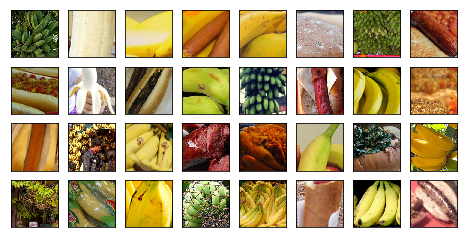

In [10]:
%matplotlib inline
import sys
sys.path.append('/home/wuying/miniconda3/lib/python3.6')
import utils

train_imgs=gluon.data.vision.ImageFolderDataset(
data_dir+'/hotdog/train',
    transform=lambda X, y: transform(X, y, train_augs)#這個是什麼意思？
) 

test_imgs = gluon.data.vision.ImageFolderDataset(
    data_dir+'/hotdog/test',
    transform=lambda X, y: transform(X, y, test_augs))

data=gluon.data.DataLoader(train_imgs,32,shuffle=True)
for X, _ in data:
    X = X.transpose((0,2,3,1)).clip(0,255)/255
    utils.show_images(X, 4, 8)
    break



In [11]:
#先从模型园里获取改良过ResNet。使用pretrained=True将会自动下载并加载从ImageNet数据集上训练而来的权重。
from mxnet.gluon.model_zoo import vision as models
pretrained_net = models.resnet18_v2(pretrained=True)

Model file is not found. Downloading.


In [12]:
pretrained_net.output

Dense(512 -> 1000, linear)

In [15]:
pretrained_net.features[1].weight.data()[0][0]


[[-0.04693392  0.11487006 -0.13209556  0.16124195 -0.21484604  0.18044543
  -0.05956454]
 [-0.00242769 -0.03129578  0.01799692  0.15277492 -0.41541672  0.38176033
  -0.13370997]
 [ 0.10314132 -0.30472746  0.59482247 -0.52606624  0.0621427   0.25646785
  -0.12772678]
 [ 0.01783164 -0.21222414  0.58199424 -0.84664404  0.57027811 -0.20741715
   0.02784866]
 [ 0.01255781 -0.02931368  0.1608634  -0.33185521  0.31180814 -0.16463067
   0.05555796]
 [-0.0167121   0.03173966  0.00400858 -0.02572511 -0.02412852  0.08885808
  -0.04472235]
 [-0.05655501  0.08309566 -0.08147315  0.02597015 -0.03567177  0.0657132
  -0.03488606]]
<NDArray 7x7 @cpu(0)>

In [17]:
#def finetune parameter about model,fearture
from mxnet import init
finetune_net=models.resnet18_v2(classes=2)
finetune_net.features=pretrained_net.features
finetune_net.output.initialize(init.Xavier())

In [18]:
def train(net, ctx, batch_size=64, epochs=10, learning_rate=0.01, wd=0.001):#wd 是什麼？
    train_data = gluon.data.DataLoader(train_imgs, batch_size, shuffle=True)
    test_data = gluon.data.DataLoader(test_imgs, batch_size)

    # 确保net的初始化在ctx上
    net.collect_params().reset_ctx(ctx)
    net.hybridize()
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    # 训练
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {
        'learning_rate': learning_rate, 'wd': wd})
    utils.train(train_data, test_data, net, loss, trainer, ctx, epochs)

In [19]:

ctx = utils.try_all_gpus()
train(finetune_net, ctx)

Start training on  [cpu(0)]
Epoch 0. Loss: 0.343, Train acc 0.85, Test acc 0.50, Time 336.6 sec
Epoch 1. Loss: 0.155, Train acc 0.94, Test acc 0.49, Time 341.4 sec
Epoch 2. Loss: 0.111, Train acc 0.96, Test acc 0.50, Time 340.5 sec
Epoch 3. Loss: 0.095, Train acc 0.97, Test acc 0.50, Time 337.5 sec
Epoch 4. Loss: 0.062, Train acc 0.98, Test acc 0.50, Time 341.4 sec
Epoch 5. Loss: 0.065, Train acc 0.98, Test acc 0.50, Time 344.1 sec
Epoch 6. Loss: 0.050, Train acc 0.98, Test acc 0.50, Time 344.4 sec
Epoch 7. Loss: 0.044, Train acc 0.99, Test acc 0.50, Time 342.1 sec
Epoch 8. Loss: 0.033, Train acc 0.99, Test acc 0.50, Time 338.7 sec
Epoch 9. Loss: 0.038, Train acc 0.99, Test acc 0.50, Time 344.5 sec


In [20]:
#上述結果的test acc效果不佳，建議使用GPU來跑？
#test acc 保持在50%，爲什麼？

In [33]:
#prediction
import matplotlib.pyplot as plt
def classify_hotdog(net,fname):
    with open(fname,'rb') as f:#這個語法沒有看懂
        img=image.imdecode(f.read())
    data, _ = transform(img, -1, test_augs)
    plt.imshow(data.transpose((1,2,0)).asnumpy()/255)#爲什麼要轉置成（1,2,0）
    data=data.expand_dims(axis=0)
    out=net(data.as_in_context(ctx[0]))
    out=nd.SoftmaxActivation(out)
    pred = int(nd.argmax(out, axis=1).asscalar())
    prob=out[0][pred].asscalar()
    label=train_imgs.synsets
    return 'With prob=%f, %s'%(prob, label[pred])
    

'With prob=1.000000, not-hotdog'

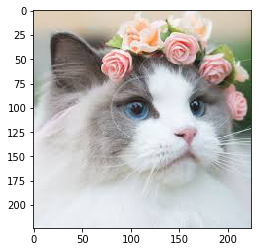

In [34]:
classify_hotdog(finetune_net, '/home/wuying/Pictures/img/cat1.jpg')

In [ ]:
#通过一个预先训练好的模型，我们可以在即使较小的数据集上训练得到很好的分类器。
#这是因为这两个任务里面的数据表示有很多共通性，例如都需要如何识别纹理、形状、边等等。而这些通常被在靠近数据的层有效的处理。
#因此，如果你有一个相对较小的数据在手，而且担心它可能不够训练出很好的模型，你可以寻找跟你数据类似的大数据集来先训练你的模型，然后再在你手上的数据集上微调。